<a href="https://colab.research.google.com/github/kartikbatra056/AllAboutTimeSeries/blob/main/TimeSeriesWithLSTMandDCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Dataset from kaggle

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d 'rohanrao/nifty50-stock-market-data'

 50% 9.00M/18.0M [00:01<00:01, 4.99MB/s]
100% 18.0M/18.0M [00:01<00:00, 11.3MB/s]


In [5]:
!unzip '/content/nifty50-stock-market-data.zip'

Archive:  /content/nifty50-stock-market-data.zip
  inflating: ADANIPORTS.csv          
  inflating: ASIANPAINT.csv          
  inflating: AXISBANK.csv            
  inflating: BAJAJ-AUTO.csv          
  inflating: BAJAJFINSV.csv          
  inflating: BAJFINANCE.csv          
  inflating: BHARTIARTL.csv          
  inflating: BPCL.csv                
  inflating: BRITANNIA.csv           
  inflating: CIPLA.csv               
  inflating: COALINDIA.csv           
  inflating: DRREDDY.csv             
  inflating: EICHERMOT.csv           
  inflating: GAIL.csv                
  inflating: GRASIM.csv              
  inflating: HCLTECH.csv             
  inflating: HDFC.csv                
  inflating: HDFCBANK.csv            
  inflating: HEROMOTOCO.csv          
  inflating: HINDALCO.csv            
  inflating: HINDUNILVR.csv          
  inflating: ICICIBANK.csv           
  inflating: INDUSINDBK.csv          
  inflating: INFRATEL.csv            
  inflating: INFY.csv                
 

In [76]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')
%matplotlib inline

In [77]:
df=pd.read_csv('/content/RELIANCE.csv',parse_dates=['Date'])
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [78]:
scaler=MinMaxScaler()
def train_test_data(data):
     '''
     Scale and split dataset.
     parameters:
       data:Time series dataset 
     returns: 
       train_df: Training data
       valid_df: Validation Data
     '''
     
     data=data.asfreq('D')

     data.fillna(method='bfill',inplace=True)

     data.fillna(method='ffill',inplace=True)

     train_df=pd.DataFrame(index=data.iloc[:-int(len(data)*0.2)].index)

     valid_df=pd.DataFrame(index=data.iloc[-int(len(data)*0.2):].index)
     
     train_df['VWAP']=scaler.fit_transform(np.reshape(data.iloc[:-int(len(data)*0.2)].values,(-1,1))).squeeze(1)
     
     valid_df['VWAP']=scaler.transform(np.reshape(data.iloc[-int(len(data)*0.2):].values,(-1,1))).squeeze(1)
     
     return train_df,valid_df

In [79]:
class RelianceDataset(Dataset):
      
      def __init__(self,data,T=10,step=1,permute=True):
          super().__init__()
          self.data=np.reshape(data.values,(data.shape[0],1))
          self.T=T
          self.permute=permute
          if permute:
            self.chunks=torch.FloatTensor(self.data).unfold(0,self.T,step).permute(0,2,1)
          else:
            self.chunks=torch.FloatTensor(self.data).unfold(0,self.T,step)
      
      def __getitem__(self,index:int): 
           
           if self.permute:
                x=self.chunks[index,:-1,:]
                y=self.chunks[index,-1,:]   
           else:
                x=self.chunks[index,:,:-1]
                y=self.chunks[index,:,-1]   
           return x,y

      def __len__(self):
          
          return self.chunks.size(0)

In [80]:
df.set_index('Date',inplace=True)
train_df,valid_df=train_test_data(df['VWAP'])
train_df.shape,valid_df.shape

((6086, 1), (1521, 1))

In [81]:
train_data=RelianceDataset(train_df,T=10)
valid_data=RelianceDataset(valid_df,T=10)
train_loader=DataLoader(train_data,batch_size=32)
valid_loader=DataLoader(valid_data,batch_size=32)

In [82]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Below neural net implementations can be found here:
[Time series implementation](https://louisenaud.github.io/time_series_prediction.html#)

# LSTM Model Training and Validation

In [83]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_stocks,h_dim,n_layers=1,drop_l=0.05,bidirect=False):
        
        super(LSTMModel,self).__init__() 
        
        if bidirect: 
          self.n_layers=2*n_layers
          n=2
        else:
          self.n_layers=n_layers  
          n=1 
        self.h_dim=h_dim

        self.lstm=nn.LSTM(n_stocks,h_dim,n_layers,batch_first=True,dropout=drop_l,bidirectional=bidirect)

        self.fc=nn.Linear(n*h_dim,n_stocks)

    def forward(self,Input):     
    
        h0,c0=torch.zeros((self.n_layers,Input.size(0),self.h_dim)).to(device),torch.zeros((self.n_layers,Input.size(0),self.h_dim)).to(device)

        output,(h0,c0)=self.lstm(Input,(h0,c0))

        out=self.fc(output[:,-1,:])
        
        return out 

In [84]:
n_stocks=1
h_dim=32
n_layers=1
drop_l=0.0
bidirect=False
model=LSTMModel(n_stocks,h_dim,n_layers,drop_l,bidirect)
model=model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.0003)

In [85]:
def valid_model(m):
  
     with torch.no_grad():
        val_loss=0.0
        val_mae=0.0
        pred_list=[]
        target_list=[]
        m.eval() 
        for x,y in valid_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             pred=m(x)

             loss=criterion(pred,y)

             val_loss+=loss.item()*x.size(0)
             
             target_list.append(y.detach().cpu().numpy())

             pred_list.append(pred.detach().cpu().numpy()) 

        val_loss/=len(valid_data)
         
        predictions=np.concatenate(pred_list,axis=0)

        target=np.concatenate(target_list,axis=0) 
        
        val_mae=mean_absolute_error(target,predictions)

        return val_loss,val_mae

In [86]:
def train_model(num_epochs,m):
     train_loss_list=[]
     val_loss_list=[]
     for i in range(num_epochs):
        epoch_loss=0.0
        train_mae=0.0
        pred_list=[]
        target_list=[]
        m.train()
        for x,y in train_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             optimizer.zero_grad()

             pred=m(x)

             loss=criterion(pred,y)

             loss.backward()

             optimizer.step()

             epoch_loss+=loss.item()*x.size(0)

             target_list.append(y.detach().cpu().numpy())

             pred_list.append(pred.detach().cpu().numpy())
             
        epoch_loss/=len(train_data)    

        predictions=np.concatenate(pred_list,axis=0)

        target=np.concatenate(target_list,axis=0) 
        
        train_mae=mean_absolute_error(target,predictions)

        val_loss,val_mae=valid_model(m)
        
        train_loss_list.append(epoch_loss)

        val_loss_list.append(val_loss) 

        print(f'Epoch:{i+1} \n Train loss:{epoch_loss:.3} , Train mae:{train_mae:.3} ,Val loss:{val_loss:.3} , Val mae:{val_mae:.3}')         
    

     print()
     ax=plt.figure(figsize=(15,5))
     plt.plot(range(len(train_loss_list)),train_loss_list,label='Training loss')
     plt.plot(range(len(train_loss_list)),val_loss_list,label='Validation loss')
     plt.title('Training and Validation Loss')
     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     plt.legend()
     plt.show()

     return m

Epoch:1 
 Train loss:0.0272 , Train mae:0.109 ,Val loss:0.0191 , Val mae:0.101
Epoch:2 
 Train loss:0.0316 , Train mae:0.128 ,Val loss:0.0161 , Val mae:0.0936
Epoch:3 
 Train loss:0.024 , Train mae:0.112 ,Val loss:0.0124 , Val mae:0.0847
Epoch:4 
 Train loss:0.0124 , Train mae:0.0799 ,Val loss:0.00686 , Val mae:0.0647
Epoch:5 
 Train loss:0.00473 , Train mae:0.0508 ,Val loss:0.00313 , Val mae:0.0432
Epoch:6 
 Train loss:0.00211 , Train mae:0.0346 ,Val loss:0.00165 , Val mae:0.0311
Epoch:7 
 Train loss:0.00122 , Train mae:0.0262 ,Val loss:0.00108 , Val mae:0.0247
Epoch:8 
 Train loss:0.000881 , Train mae:0.0217 ,Val loss:0.000835 , Val mae:0.0211
Epoch:9 
 Train loss:0.000718 , Train mae:0.0191 ,Val loss:0.00071 , Val mae:0.019
Epoch:10 
 Train loss:0.000624 , Train mae:0.0172 ,Val loss:0.00064 , Val mae:0.0178
Epoch:11 
 Train loss:0.000564 , Train mae:0.0159 ,Val loss:0.000597 , Val mae:0.0169
Epoch:12 
 Train loss:0.000522 , Train mae:0.015 ,Val loss:0.000567 , Val mae:0.0163
Epoch:1

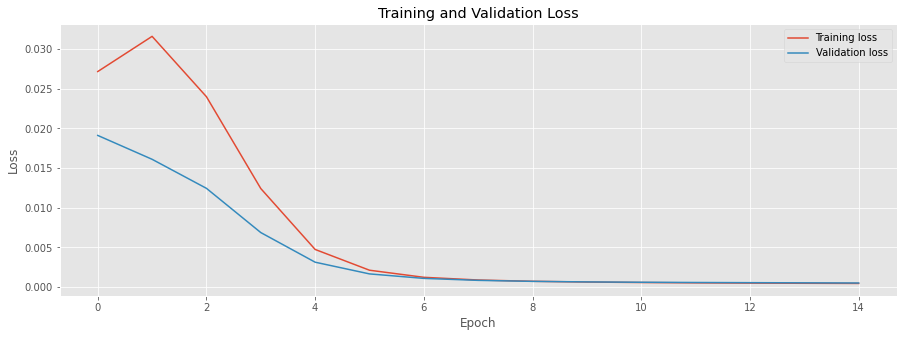

In [87]:
num_epochs=15
if __name__=='__main__':
    model=train_model(num_epochs,model)

In [88]:
def plot_timeseries(m,title):
    '''
    Function to plot Time series 
    parameters:
       m: Trained model
       title:Title for graph
    output:
       plot Train data,valid_data,predictions   
    '''
    with torch.no_grad():
      m.eval()
      train_=[]
      pred_=[]
      val_=[]
      plt.figure(figsize=(15,5))
     
      for x,y in train_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             pred=m(x)

             train_.append(y.detach().cpu().numpy())

             pred_.append(pred.detach().cpu().numpy())
      
      train=np.concatenate(train_,axis=0)
       
      plt.plot(range(len(train)),train,label='Train label')
      
      for x,y in valid_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             pred=m(x)

             val_.append(y.detach().cpu().numpy())

             pred_.append(pred.detach().cpu().numpy())       
      
      val=np.concatenate(val_,axis=0)

      pred=np.concatenate(pred_,axis=0)

      plt.plot(range(len(train),len(train)+len(val)),val,label='Validation label')

      plt.plot(range(len(pred)),pred,'g',label='Prediction')      

      plt.title(title)

      plt.legend()

      plt.show()

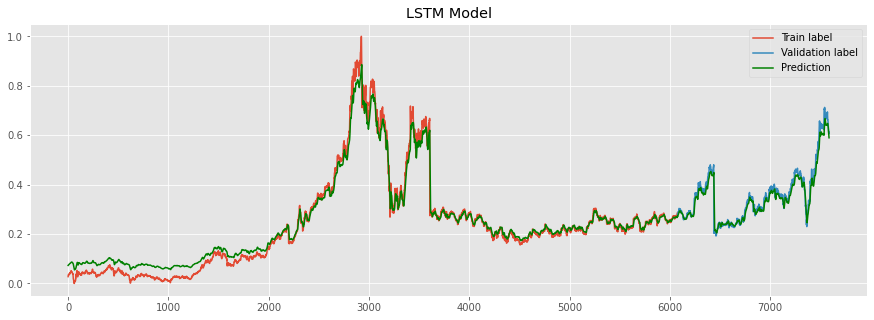

In [89]:
plot_timeseries(model,'LSTM Model')

# DCNN Model Training and Validation

In [90]:
train_data=RelianceDataset(train_df,T=10,permute=False)
valid_data=RelianceDataset(valid_df,T=10,permute=False)
train_loader=DataLoader(train_data,batch_size=32)
valid_loader=DataLoader(valid_data,batch_size=32)

In [115]:
class DCNN(nn.Module):
    
    def __init__(self,n_stocks,h_dim,n_layers=2,drop=0.5,dilation=2):
        
        super(DCNN,self).__init__() 
        
        self.h_dim=h_dim
        
        self.first_layer=nn.Conv1d(n_stocks,h_dim,kernel_size=2,dilation=dilation)    

        self.hidden_layers=nn.ModuleList([nn.Conv1d(h_dim,h_dim,kernel_size=2,dilation=dilation) for i in range(n_layers)])

        self.final_layer=nn.Conv1d(h_dim,n_stocks,kernel_size=2,dilation=dilation)

        self.relu=nn.ReLU()

        self.drop=nn.Dropout(drop)

    def forward(self,Input):     
    
        output=self.relu(self.first_layer(Input))
        
        for layer in self.hidden_layers:
            output=self.drop(self.relu(layer(output)))    
        
        out=self.final_layer(output)
        
        return out.view(Input.size(0),-1) 

In [116]:
n_stocks=1
h_dim=32
d_model=DCNN(n_stocks,h_dim,drop=0.25)
d_model=d_model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(d_model.parameters(),lr=0.0001)

Epoch:1 
 Train loss:0.0512 , Train mae:0.161 ,Val loss:0.0184 , Val mae:0.106
Epoch:2 
 Train loss:0.0278 , Train mae:0.121 ,Val loss:0.0111 , Val mae:0.0782
Epoch:3 
 Train loss:0.0228 , Train mae:0.112 ,Val loss:0.00832 , Val mae:0.0688
Epoch:4 
 Train loss:0.0161 , Train mae:0.0947 ,Val loss:0.00565 , Val mae:0.0592
Epoch:5 
 Train loss:0.0122 , Train mae:0.081 ,Val loss:0.00372 , Val mae:0.0509
Epoch:6 
 Train loss:0.00826 , Train mae:0.0666 ,Val loss:0.00227 , Val mae:0.0414
Epoch:7 
 Train loss:0.00644 , Train mae:0.0585 ,Val loss:0.00139 , Val mae:0.0323
Epoch:8 
 Train loss:0.0054 , Train mae:0.0526 ,Val loss:0.000942 , Val mae:0.0254
Epoch:9 
 Train loss:0.00504 , Train mae:0.0501 ,Val loss:0.000797 , Val mae:0.0227
Epoch:10 
 Train loss:0.00471 , Train mae:0.0481 ,Val loss:0.000814 , Val mae:0.0234
Epoch:11 
 Train loss:0.00467 , Train mae:0.0469 ,Val loss:0.000597 , Val mae:0.0182
Epoch:12 
 Train loss:0.00427 , Train mae:0.0452 ,Val loss:0.000641 , Val mae:0.0193
Epoch:13 

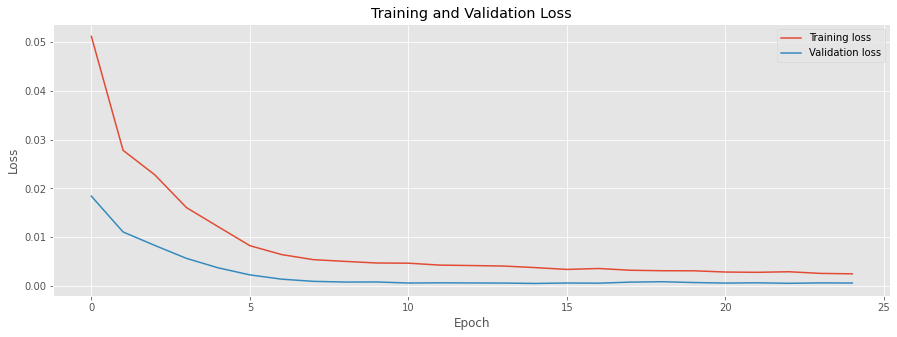

In [117]:
num_epochs=25
if __name__=='__main__':
    model=train_model(num_epochs,d_model)

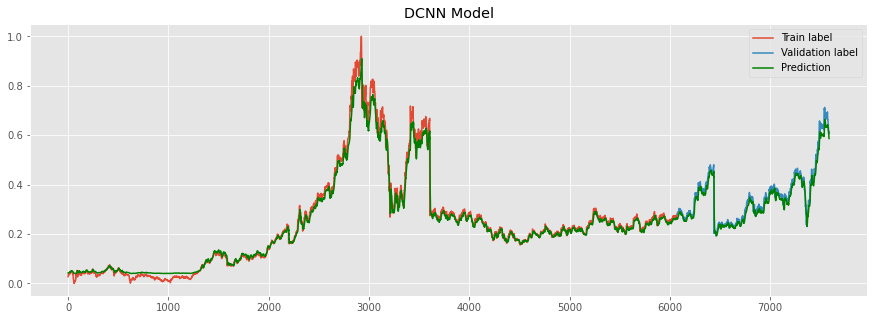

In [118]:
plot_timeseries(d_model,'DCNN Model')